# Approximate Bayesian Computation

The following tutorial demonstrates how one may calibrate a simulation model via Approximate Bayesian Computation (ABC) using `calisim`. We will first import our required dependencies.

In [28]:
from calisim.data_model import (
	DistributionModel,
	ParameterDataType,
	ParameterSpecification,
)
from calisim.example_models import SirOdesModel
from calisim.abc import (
	ApproximateBayesianComputationMethod,
	ApproximateBayesianComputationMethodModel,
)
from calisim.statistics import L2Norm
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp

import warnings
warnings.filterwarnings("ignore")

## SIR Model Parameters and Initial Conditions

We next define our forward model. We will use an SIR (susceptible, infected, and recovered) compartmental model, combined with SciPy's solver for ordinary differential equations. The SIR model is expressed as a system of ordinary differential equations where:

| Parameter | Value | Description |
|-----------|-------|-------------|
| β (beta)  | 0.4   | Infection rate: probability of transmission per contact per time unit |
| γ (gamma) | 0.1   | Recovery rate: fraction of infected recovering per time unit |
|           |       | **Average infectious period = 1 / γ = 10 time units** |

With the following compartments:

| Compartment | Symbol | Initial Value | Description |
|------------|--------|---------------|-------------|
| Susceptible | S0     | 999           | Individuals who can catch the disease (N - I0 - R0) |
| Infected    | I0     | 1.0           | Individuals currently infected and can spread the disease |
| Recovered   | R0     | 0             | Individuals recovered or removed; no longer infectious |

In [29]:
def sir_simulate(parameters: dict) -> np.ndarray | pd.DataFrame:
    def dX_dt(_: np.ndarray, X: np.ndarray) -> np.ndarray:
        S, I, _ = X 
        dotS = -parameters["beta"] * S * I / parameters["N"]
        dotI = (
            parameters["beta"] * S * I / parameters["N"] - parameters["gamma"] * I
        )
        dotR = parameters["gamma"] * I
        return np.array([dotS, dotI, dotR])

    X0 = [parameters["S0"], parameters["I0"], parameters["R0"]]
    t = (parameters["t"].min(), parameters["t"].max())
    x_y = solve_ivp(
        fun=dX_dt, y0=X0, t_span=t, t_eval=parameters["t"].values.flatten()
    ).y

    df = pd.DataFrame(dict(dotS=x_y[0, :], dotI=x_y[1, :], dotR=x_y[2, :]))
    return df

We will perform a simulation study with the following ground-truth parameters:

In [30]:
model = SirOdesModel()
pd.DataFrame(model.GROUND_TRUTH, index=[0]) 

,beta,gamma,N,I0,R0,S0
0,0.4,0.1,1000,1.0,0,999.0


When supplied to our forward model, these ground-truth parameters will generate the observed data below:

In [31]:
observed_data = model.get_observed_data()
observed_data.head(6)

,dotS,dotI,dotR,day
0,999.000000,1.000000,0.000000,0
1,998.534208,1.349201,0.116592,1
2,997.906105,1.819995,0.273899,2
3,997.059813,2.454180,0.486007,3
4,995.919926,3.308098,0.771976,4
5,994.385263,4.457212,1.157524,5


Let's view the trajectory of infected individuals over time in days.

<Axes: xlabel='day', ylabel='dotI'>

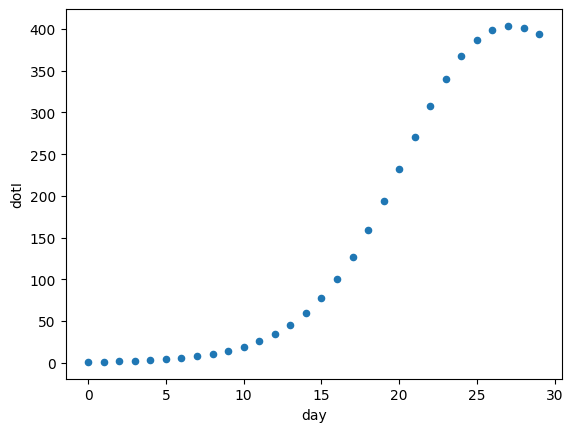

In [32]:
observed_data.plot.scatter("day", "dotI")

## Bayesian Calibration via Approximate Bayesian Computation Sequential Monte Carlo

Next, let's use `calisim` to perform Bayesian calibration via ABC using the simulated and observed number of infections. We will apply the `L2 norm` as our distance metric, with the aim of minimising the discrepancy between simulated and observed data.

To start with, we'll need to define our `ParameterSpecification` parameter specification using Normally distributed priors:

In [33]:
parameter_spec = ParameterSpecification(
	parameters=[
		DistributionModel(
			name="beta",
			distribution_name="normal",
			distribution_args=[0.35, 0.05],
			data_type=ParameterDataType.CONTINUOUS,
		),
		DistributionModel(
			name="gamma",
			distribution_name="normal",
			distribution_args=[0.08, 0.01],
			data_type=ParameterDataType.CONTINUOUS,
		),
	]
)

This contains information concerning the various parameter names, probability distributions, ranges, distribution parameters, and data types.

We next need to define a wrapper function around our forward model to ensure there's compatibility with the `calisim` API.

In [34]:
def abc_func(
	parameters: dict, simulation_id: str, observed_data: np.ndarray | None, t: pd.Series
) -> float | list[float]:
    simulation_parameters = model.GROUND_TRUTH.copy()
    simulation_parameters["t"] = t
    
    for k in ["beta", "gamma"]:
        simulation_parameters[k] = parameters[k]
    
    simulated_data = sir_simulate(simulation_parameters).dotI.describe().values
    metric = L2Norm()
    discrepancy = metric.calculate(observed_data, simulated_data)
    return discrepancy

The last step is to create a `ApproximateBayesianComputationMethodModel` specification for the calibration procedure itself, which we then supply to a `ApproximateBayesianComputationMethod` calibrator. We'll use the `ABC Sequential Monte Carlo` method via the [pyABC engine](https://pyabc.readthedocs.io/en/latest/).

In [35]:
specification = ApproximateBayesianComputationMethodModel(
	experiment_name="pymc_approximate_bayesian_computation",
	parameter_spec=parameter_spec,
	observed_data=observed_data.dotI.describe().values,
	n_init=25,
	walltime=1, 
	epsilon=0.1,
	n_bootstrap=15,
	min_population_size=5,
	output_labels=["Number of Infected"],
	calibration_func_kwargs=dict(t=observed_data.day),
	method_kwargs=dict(max_total_nr_simulations=500, max_nr_populations=20, min_acceptance_rate=0.),
)

calibrator = ApproximateBayesianComputationMethod(
	calibration_func=abc_func, specification=specification, engine="pyabc"
)

Finally, we'll run the calibration procedure. This is composed of 3 steps:

1. **Specify**: Define your calibration problem: Parameter distributions, observed data, objective/discrepancy function, and calibration settings (like algorithm, directions, iterations)
2. **Execute**: Run the actual calibration process (simulation + optimization/inference)
3. **Analyze**: Process, summarize, and optionally save plots/metrics of the calibration results

Or **SEA**.

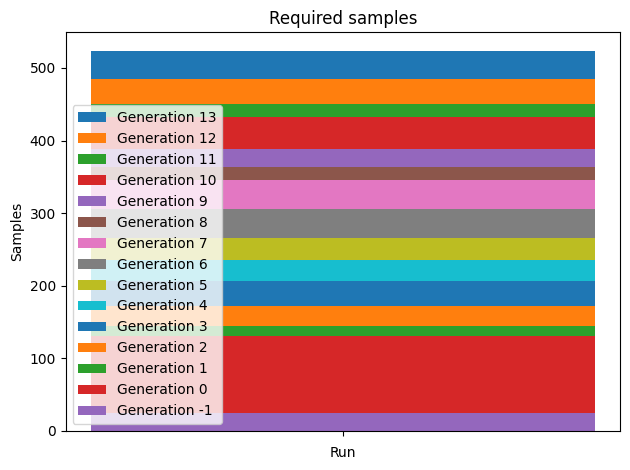

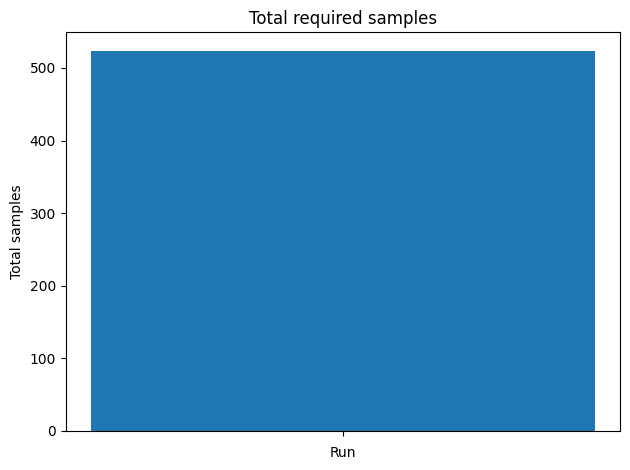

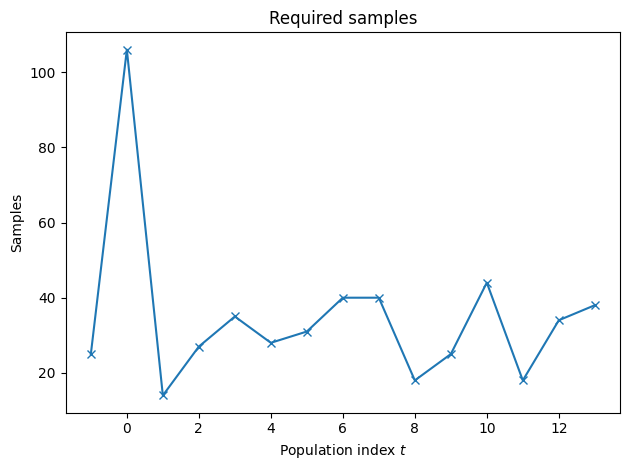

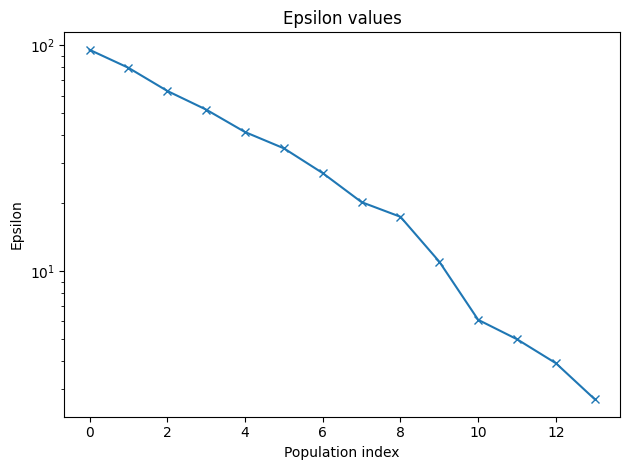

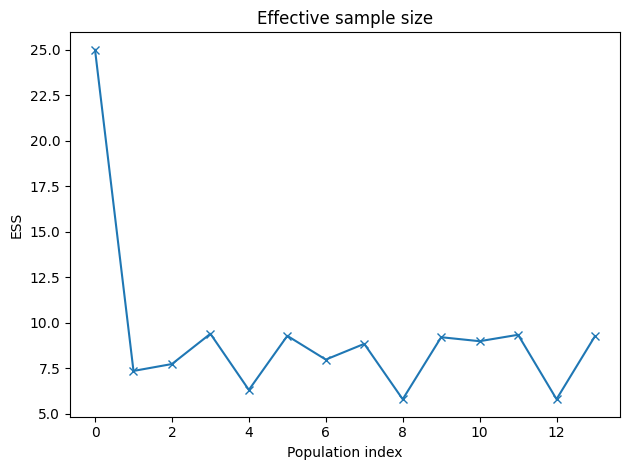

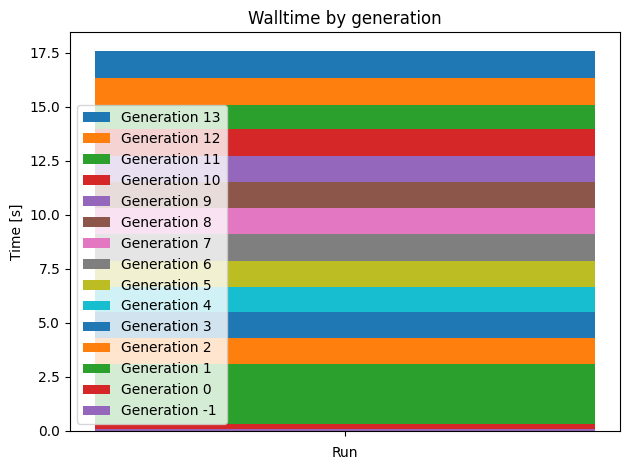

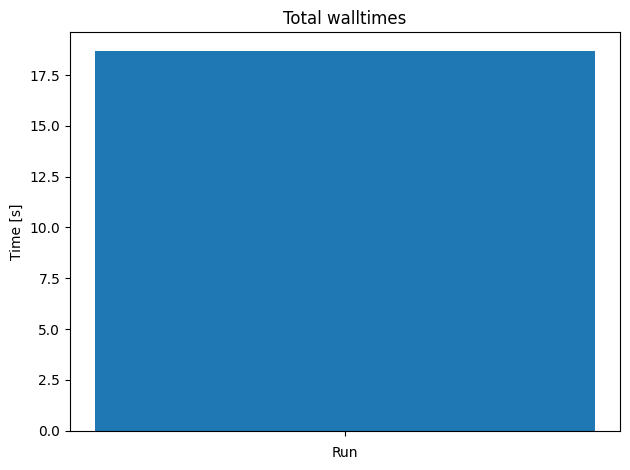

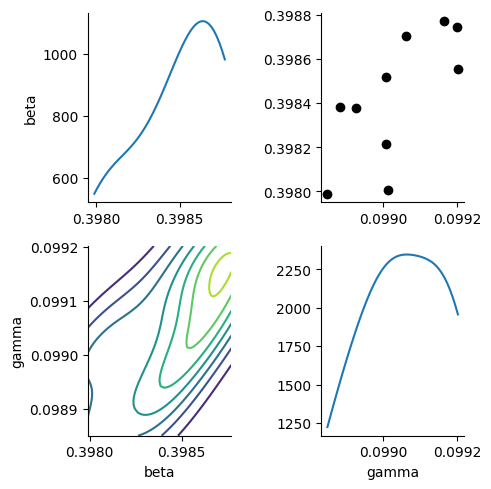

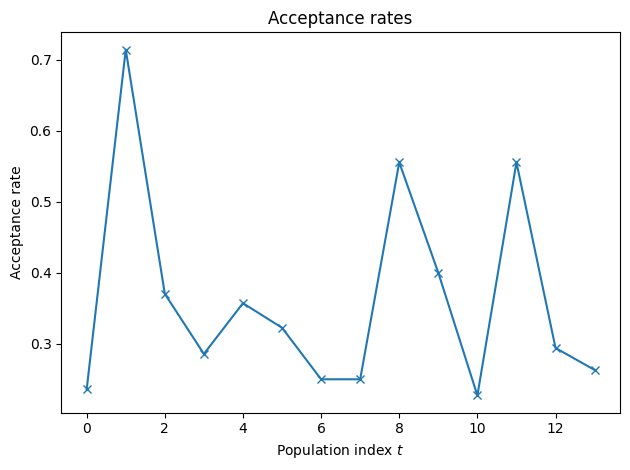

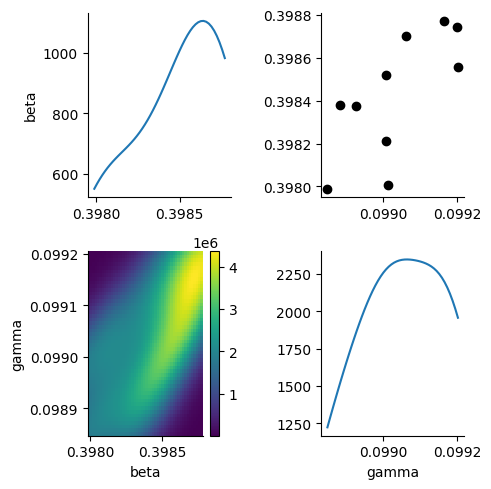

In [36]:
import logging
logging.getLogger("pyabc").setLevel(logging.INFO)
calibrator.specify().execute().analyze()

Let's view the parameter estimates produced by the calibrator, with some measure of uncertainty. 

In [37]:
pd.DataFrame([
    { "parameter": estimate.name, "estimate": estimate.estimate, "uncertainty": estimate.uncertainty, "ground truth": model.GROUND_TRUTH[estimate.name] }
    for estimate in calibrator.get_parameter_estimates().estimates
])

,parameter,estimate,uncertainty,ground truth
0,beta,0.398426,0.000286,0.4
1,gamma,0.099032,0.000126,0.1


The ABC calibrator is able to retrieve the ground-truth parameter values from our simulation study.